# <font color=green> Example project #2: X-ray Binary Vela X-1  </font>
***
## Introduction
This thread serves as a comprehensive, step-by-step guide illustrating a miniature science project leveraging XMM-Newton data. The focal point is the retrieval and processing of data associated with the high-mass X-ray binary Vela X-1, which is composed of a neutron star. Subsequently, the derived spectrum can undergo in depth analysis using Xspec in accordance with the user's wishes, where if wanted they can apply various models to draw insightful conclusions from the observational data.

Moreover, this thread exemplifies the practical utilization of the XMM-SAS Datalab for research purposes. This platform facilitates a streamlined experience, enabling users to promptly obtain data in their preferred format and conduct comprehensive analyses—all within a unified space. Importantly, this eliminates the need for additional package installations or the inconvenience of navigating between disparate platforms.

On this thread we demonstrate applications of methods such as SAS start-up, reprocessing the ODF to generate concatenated EPIC event lists, extracting ligthcurves, checking for pile-up, and extracting a spectrum which can be used for scientific analysis.

## Background Information

Vela X-1 is a prominent X-ray binary system located in the Vela constellation. Discovered in the early 1970s by the Uhuru X-ray satellite, however it has been observed by nearly all X-ray observatories even multiple times. This binary system features a pulsar—a rapidly rotating neutron star—as its compact object. The companion star is a massive B-type supergiant, and the system is characterized by the transfer of mass from the companion to the neutron star. As the material from the donor star accretes onto the neutron star's surface, it emits intense X-ray radiation, making Vela X-1 detectable in X-ray observations, while also providing a rich spectrum with various emission lines. The high rate of rotation of the neutron star, combined with the mass transfer process, results in the system's dynamic and variable behavior. Vela X-1's study has contributed valuable insights into the physics of accretion processes, neutron star characteristics, and the evolution of binary systems involving compact objects.

The particular observation we chose is with ObsID of 0841890201. Total exposures are five with 3 EPIC, 0 OM, and 2 RGS. This is a very bright source, hence EPIC-pn exposure is in timing mode, and when processing adjustments such as pile-up correction will be necessary.


## Suggested Further Reading
* https://doi.org/10.1051/0004-6361/202040272
* https://heasarc.gsfc.nasa.gov/xanadu/xspec/python/html/index.html
* https://ui.adsabs.harvard.edu/link_gateway/2023A&A...674A.147D/doi:10.48550/arXiv.2303.09631
* https://ui.adsabs.harvard.edu/link_gateway/2023ApJ...950..170R/doi:10.48550/arXiv.2302.10953

## Further Credits
Special thanks and recognition to [Camille Diez](https://www.camillediez.com/) for sharing her research method, knowledge, and help.

***

Import the following libraries listed below:

In [1]:
from pysas.wrapper import Wrapper as w
import os.path
from os import path
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter  # For formatting axis labels
from xspec import *
import re
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)
from tools.js9helper import *
from tools.plotLC import *
import shutil
from IPython.display import display, Image

* ### SAS start-up

Use the 'expanduser' function from the 'os.path' module to get the home directory of the current user. The variable 'home' now will contain the path to the home directory of the current user:

In [2]:
home = os.path.expanduser('~')

Create the working dircetory where all the files produced along the process can be stroed and accessed easily below. Make sure to save your files inside the `my_workspace` folder for permanent storage, as everything stored outside of this folder will be erased every time the Datalab is closed.

In [15]:
wdir=f'{home}/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec'
#os.mkdir(wdir) #uncomment this line if you want to make the directory
os.chdir(wdir)

Define the path to the CCF files provided as a data volume by Datalabs. Hence the user des not need to download any CCF files nor worry about updates. For more information on how to add them in your Datalabs data volume, please refer to the general guidelines on the ESA Datalabs Help section.

In [5]:
os.environ['SAS_CCFPATH'] = f'{home}/data/user/pub'

Before starting, it is a good practice to sun `sasver` to check which SAS variables are defined.

In [6]:
inargs = []
t = w('sasver', inargs)
t.run()


    XMM-Newton SAS - release and build information

    SAS release: xmmsas_20230412_1735-21.0.0
    Compiled on: Sun Apr 16 21:03:02 CEST 2023
    Compiled by: sasbuild@sasbld01n.iuser.lan
    Platform   : Ubuntu20.04

    SAS-related environment variables set:

    
SAS_DIR        = /usr/local/SAS/xmmsas_20230412_1735
SAS_PATH       = /usr/local/SAS/xmmsas_20230412_1735
SAS_CCFPATH    = /home/egulbaha/data/user/pub


Next, we execute the command `startsas`. The task downloads the ODFs of the odfid the user defines in the working directory defined earlier. Please refer to the [XMM-Newton Science Archive](https://www.cosmos.esa.int/web/xmm-newton/xsa) to search through the catalogue for different observation IDs. We will be working with ODF 0841890201.

In [7]:
t = w('startsas',['odfid=0841890201'])
t.run()

startsas - WARNING - Executing /usr/local/SAS/xmmsas_20230412_1735/lib/python/pysas/startsas/startsas.py {'odfid': '0841890201', 'workdir': 'pwd', 'sasfiles': 'no', 'sas_ccf': '', 'sas_odf': '', 'level': 'ODF', 'cifbuild_opts': '', 'odfingest_opts': ''}
INFO:startsas:LHEASOFT = /usr/local/heasoft-6.30.1/x86_64-pc-linux-gnu-libc2.31
INFO:startsas:SAS_DIR = /usr/local/SAS/xmmsas_20230412_1735
INFO:startsas:SAS_CCFPATH = /home/egulbaha/data/user/pub
INFO:startsas:startsas was initiated from /media/user/xmm_sas_datalabs/data/VelaJupyter17Dec
INFO:startsas:Will download ODF with level ODF
INFO:startsas:Requesting odfid  = 0841890201 to XMM-Newton Science Archive

INFO:startsas:Downloading 0841890201, level ODF


Requesting odfid  = 0841890201 to XMM-Newton Science Archive





INFO:startsas:0841890201.tar.gz downloaded.
INFO:startsas:Creating directory 0841890201 ...



Creating directory 0841890201 ...


INFO:startsas:Unpacking 0841890201.tar.gz ...



Unpacking 0841890201.tar.gz ...



INFO:startsas:0841890201.tar.gz extracted successfully!
INFO:startsas:0841890201.tar.gz removed
INFO:startsas:Unpacking 3553_0841890201.TAR ...


Unpacking 3553_0841890201.TAR ...


INFO:startsas:3553_0841890201.TAR removed
INFO:startsas:File MANIFEST.704820 exists
INFO:startsas:Setting SAS_ODF = /media/user/xmm_sas_datalabs/data/VelaJupyter17Dec/0841890201
INFO:startsas:Running cifbuild...
** cifbuild: warning (NoMatchingCcfConstituents), Could not find any CCF constituents matching the search criteria:

   Analysis date    = 2024-12-17T13:43:49.000
   Observation date = 2019-05-03T21:14:00.000
   ccfpath          = 
   Category         = XMMCCF
   File glob        = *.ccf|*.CCF
   CCF search path  = /home/egulbaha/data/user/pub
INFO:startsas:CIF file ccf.cif created
INFO:startsas:Setting SAS_CCF = /media/user/xmm_sas_datalabs/data/VelaJupyter17Dec/ccf.cif
INFO:startsas:Running odfingest...



Setting SAS_ODF = /media/user/xmm_sas_datalabs/data/VelaJupyter17Dec/0841890201

Running cifbuild...
cifbuild:- Executing (routine): cifbuild calindexset=ccf.cif ccfpath=. withccfpath=no usecanonicalname=no recurse=no fileglob=*.ccf|*.CCF fullpath=no observationdate=now withobservationdate=no analysisdate=now category=XMMCCF ignorecategory=no masterindex=no masterindexset=ccf.mif withmasterindexset=no append=no  -w 1 -V 4
cifbuild:- cifbuild (cifbuild-4.10.1)  [xmmsas_20230412_1735-21.0.0] started:  2024-12-17T13:43:49.000
cifbuild:- Will ask the analysis date to the OAL.
cifbuild:- Using the ODF 3553_0841890201 found in /media/user/xmm_sas_datalabs/data/VelaJupyter17Dec/0841890201
cifbuild:- Observation date: 2019-05-03T21:14:00.000
cifbuild:- Analysis date: 2024-12-17T13:43:49.000
cifbuild:- cifbuild (cifbuild-4.10.1)  [xmmsas_20230412_1735-21.0.0] ended:    2024-12-17T13:43:49.000

Setting SAS_CCF = /media/user/xmm_sas_datalabs/data/VelaJupyter17Dec/ccf.cif

Running odfingest...
od

** odfingest: error (DataSetNotFound), The CCF does not contain a EMOS1/MODEPARAM file - also tried the version in the telescope and satellite scope
startsas - ERROR - odfingest failed to complete
ERROR:startsas:odfingest failed to complete


Exception: odfingest failed to complete.

* ### Running `epproc`

In [168]:
inargs = [f'sas_ccf={wdir}/ccf.cif', f'sas_odf={wdir}/3553_0841890201_SCX00000SUM.SAS', f'workdir={wdir}']

w('startsas', inargs).run()

startsas - WARNING - Executing /usr/local/SAS/xmmsas_20230412_1735/lib/python/pysas/startsas/startsas.py {'odfid': '', 'workdir': '/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec', 'sasfiles': 'yes', 'sas_ccf': '/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/ccf.cif', 'sas_odf': '/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/3553_0841890201_SCX00000SUM.SAS', 'level': 'ODF', 'cifbuild_opts': '', 'odfingest_opts': ''}
INFO:startsas:LHEASOFT = /usr/local/heasoft-6.30.1/x86_64-pc-linux-gnu-libc2.31
INFO:startsas:SAS_DIR = /usr/local/SAS/xmmsas_20230412_1735
INFO:startsas:SAS_CCFPATH = /home/egulbaha/data/user/pub
INFO:startsas:startsas was initiated from /media/user/xmm_sas_datalabs/data/VelaJupyter04Dec
INFO:startsas:Work directory = /home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec
INFO:startsas:Changed directory to /home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec
INFO:startsas:Will download OD



        Starting SAS session
    
        Working directory = /home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec
    
        
SAS_CCF = /home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/ccf.cif
SAS_ODF = /home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/3553_0841890201_SCX00000SUM.SAS


We will now apply `epproc` for this observation that has been taken in timing mode. Timing mode can be used for very bright sources (such as this observation of Vela X-1), which require a shorter readout time. In timing mode the arrival times of individual X-ray photons are recorded with high precision. Rather than focusing on spatial information, this mode emphasizes the temporal aspects of X-ray events, making it ideal for studying time-dependent phenomena. Timing mode can allow us to extract detailed information about periodicities, rotational periods, and other temporal characteristics, providing insights into the dynamic behavior of Vela X-1. The default intrinsic timing mode calibration settings when running the `epproc` task are shown below:
```
TIMING: withrdpha=“Y”, withxrlcorrection=“Y”, runepreject=“Y”, runepfast=“N”
```
One can change the default calibration settings by adding `withdefaultcal=“N”` as argument of the `epproc` task and set the aforementioned calibration parameters to their own preference. If further information is needed please refer to the thread *How to Reprocess ODFS to Generate Calibrated and Concatenated EPIC Event Lists* and to the Appendix of [Diez et al. (2023)](https://arxiv.org/pdf/2303.09631.pdf) for issues with default calibration settings when in timing mode. For this exercise, we apply the same calibration corrections as in [Diez et al. (2023)](https://arxiv.org/pdf/2303.09631.pdf).

In [16]:
# SAS Command
cmd    = 'epproc'  # SAS task to be executed

# Arguments of SAS Command, leave empty if you want to run with default calibration settings for timing mode
inargs = ['withdefaultcal=no', 'withrdpha=no', 'runepreject=yes', 'withxrlcorrection=yes', 'runepfast=yes']        #remove arguments for default cal
# comma separated arguments for SAS task

print("   SAS command to be executed: "+cmd+", with arguments; \n")
inargs

   SAS command to be executed: epproc, with arguments; 



['withdefaultcal=no',
 'withrdpha=no',
 'runepreject=yes',
 'withxrlcorrection=yes',
 'runepfast=yes']

In [17]:
print("Running epproc ..... \n")

# Check if epproc has already run. If it has, do not run again 
exists = 0
pnevt_list = []
for root, dirs, files in os.walk("."):
    for filename in files:
        if (filename.find('EPN') != -1) and filename.endswith('TimingEvts.ds'):
            pnevt_list.append(filename)
            exists = 1
if exists:
    print(" > " + str(len(pnevt_list)) + " EPIC-pn event list found. Not running epproc again.\n")
    for x in pnevt_list:
        print("    " + x + "\n")
    print("..... OK")
else:
    w(cmd,inargs).run()      # <<<<< Execute SAS task
    exists = 0
    pnevt_list = []
    for root, dirs, files in os.walk("."):
        for filename in files:
            if (filename.find('EPN') != -1) and filename.endswith('TimingEvts.ds'):
                pnevt_list.append(filename)
                exists = 1
    if exists:
        print(" > " + str(len(pnevt_list)) + " EPIC-pn event list found after running epproc.\n")
        for x in pnevt_list:
            print("    " + x + "\n")
        print("..... OK")
    else:
        print("Something has gone wrong with epproc. I cant find any event list files after running. \n")

Running epproc ..... 

 > 1 EPIC-pn event list found. Not running epproc again.

    3553_0841890201_EPN_S003_TimingEvts.ds

..... OK


* ### Do I need to apply filtering for flaring particle background?

You do not always need to apply filtering for flaring particle background. In this scenario the source brightness is high enough to not require any filtering, because the flux of the object would be in every case larger than the possible flaring particle background. However, let us demonstrate this is indeed the case for demonstration purposes by inspecting the source and flaring particle background lightcurves.

We define our event file produced n the previous step:

In [18]:
eventfile = wdir+'/3553_0841890201_EPN_S003_TimingEvts.ds'

In [12]:
# Define a SAS filter expression to derive a background rate cut

pn_pattern   = 0        # pattern selection
pn_pi_min    = 10000.   # Low energy range eV
pn_pi_max    = 12000.   # High energy range eV
pn_threshold = 0.4      # cts/sec (only used here for display purposes)

out_LCFile   = wdir+'/PN_bkg_nrjthreshold.fits'  # Name of the output BKG lightcurve

The argument values can be altered depending on the user, these are only display numbers. After observing the produced light curve, the user can either come back and change values above and rerun the kernels or just copy the same kernels with the new values.

In [14]:
# SAS Command
cmd        = "evselect" # SAS task to be executed                  

# Arguments of SAS Command
expression = f'#XMMEA_EP&&(PI>={pn_pi_min}&&PI<={pn_pi_max})&&(PATTERN=={pn_pattern})'  # event filter expression
inargs     = [f'table={eventfile}','withrateset=Y',f'rateset={out_LCFile}','maketimecolumn=Y','timebinsize=100','makeratecolumn=Y',f'expression={expression}']

print("   Filter expression to use: "+expression+" \n")
print("   SAS command to be executed: "+cmd+", with arguments; \n")
inargs

   Filter expression to use: #XMMEA_EP&&(PI>=10000.0&&PI<=12000.0)&&(PATTERN==0) 

   SAS command to be executed: evselect, with arguments; 



['table=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaX1/3553_0841890201_EPN_S003_TimingEvts.ds',
 'withrateset=Y',
 'rateset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaX1/PN_bkg_nrjthreshold.fits',
 'maketimecolumn=Y',
 'timebinsize=100',
 'makeratecolumn=Y',
 'expression=#XMMEA_EP&&(PI>=10000.0&&PI<=12000.0)&&(PATTERN==0)']

In [15]:
%%capture
# Execute SAS task with parameters

w(cmd, inargs).run()

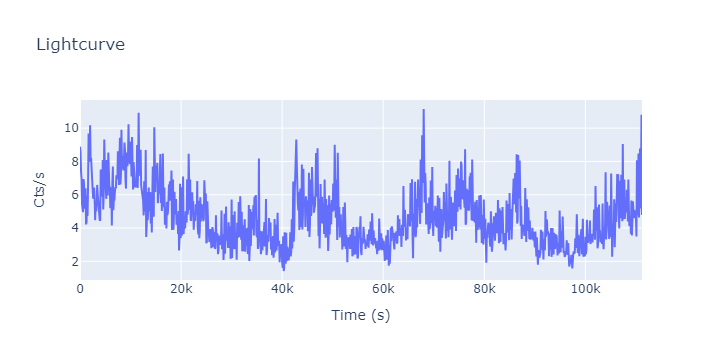

In [20]:
# Plot BKG lightcurve
name= ["flaring particle background"]
file_paths = [out_LCFile]

# Call the function to plot light curves
plotLC(file_paths, name, threshold = None)


In [13]:
pn_pi_min    = 150   
out_file = wdir + '/PN_sr_Rthreshold.fits'

In [14]:
# SAS Command
cmd        = "evselect" # SAS task to be executed                  

# Arguments of SAS Command
expression = f'#XMMEA_EP&&(PI>={pn_pi_min})'  # event filter expression
inargs     = [f'table={eventfile}','withrateset=Y',f'rateset={out_file}','maketimecolumn=Y','timebinsize=283.44','makeratecolumn=Y',f'expression={expression}']

print("   Filter expression to use: "+expression+" \n")
print("   SAS command to be executed: "+cmd+", with arguments; \n")
inargs

   Filter expression to use: #XMMEA_EP&&(PI>=150) 

   SAS command to be executed: evselect, with arguments; 



['table=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaX1/3553_0841890201_EPN_S003_TimingEvts.ds',
 'withrateset=Y',
 'rateset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaX1/PN_sr_Rthreshold.fits',
 'maketimecolumn=Y',
 'timebinsize=283.44',
 'makeratecolumn=Y',
 'expression=#XMMEA_EP&&(PI>=150)']

In [18]:
%%capture
# Execute SAS task with parameters

w(cmd, inargs).run()

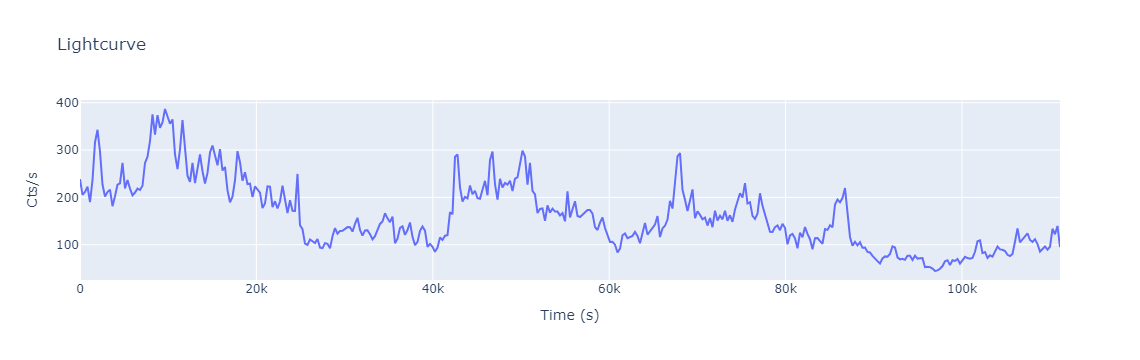

In [19]:
name= [" "]
file_paths = [out_file]

# Call the function to plot light curves
plotLC(file_paths, name, threshold = None)


* ### Barycentric correction

Here we apply a barycentric correction, necessary
for high resolved timing analysis. 

After inspecting the light curve, the user can choose to remove the threshold value altogether if they see no need for it. This is particularly applicable in scenarios where the source is bright enough, rendering particle background filtering unnecessary. Hence we can run `evselect` in the following conditions:

In [20]:
pn_pi_min    = 150   
out_file = wdir + '/PN_clean_evt.fits'

In [21]:
# SAS Command
cmd        = "evselect" # SAS task to be executed                  

# Arguments of SAS Command
expression = f'#XMMEA_EP&&(PI>={pn_pi_min})'  # event filter expression
inargs     = [f'table={eventfile}','withfilteredset=Y',f'filteredset={out_file}','destruct=Y','keepfilteroutput=T',f'expression={expression}']

print("   Filter expression to use: "+expression+" \n")
print("   SAS command to be executed: "+cmd+", with arguments; \n")
inargs

   Filter expression to use: #XMMEA_EP&&(PI>=150) 

   SAS command to be executed: evselect, with arguments; 



['table=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/3553_0841890201_EPN_S003_TimingEvts.ds',
 'withfilteredset=Y',
 'filteredset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_clean_evt.fits',
 'destruct=Y',
 'keepfilteroutput=T',
 'expression=#XMMEA_EP&&(PI>=150)']

In [22]:
%%capture
# Execute SAS task with parameters

w(cmd, inargs).run()

Next we shall run the task `barycen`. The `barycen` task is designed to convert times from the local satellite frame to Barycentric Dynamical Time (TDB) using a specified table in a dataset containing times in XMM MET (Mission Elapsed Time) format. The task checks if barycentric conversion has been performed, exits if true, and proceeds to correct time tags in the specified column. Additionally, it converts interval start and stop times to TDB if a Good Time Interval extension exists and corrects time tags in EXPOSU tables if the relevant parameter is enabled. The task updates TIMEREF, TSTART, TSTOP, and TELAPSE attributes where necessary.

In [23]:
# Use the 'copy' function from the 'shutil' module to copy the file 'PN_clean_evt.fits'
# to a new file named 'PN_clean_evt_nobarycen_cor.fits'.
shutil.copy('PN_clean_evt.fits', 'PN_clean_evt_nobarycen_cor.fits')

'PN_clean_evt_nobarycen_cor.fits'

In [24]:
table = wdir + "/PN_clean_evt.fits"

In [25]:
# SAS Command
cmd        = "/usr/local/SAS/xmmsas_20230412_1735/bin/barycen" # SAS task to be executed                  

# Arguments of SAS Command
inargs     = ['withtable=true', f'table={table}:EVENTS']

print("   SAS command to be executed: "+cmd+", with arguments; \n")
inargs

   SAS command to be executed: /usr/local/SAS/xmmsas_20230412_1735/bin/barycen, with arguments; 



['withtable=true',
 'table=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_clean_evt.fits:EVENTS']

In [26]:
#|%%capture
# Execute SAS task with parameters

w(cmd, inargs).run()

Exception: Does not exist any file named /usr/local/SAS/xmmsas_20230412_1735/bin/barycen.par. Wrong syntax?

Now we have created filtered PN event list files with and without barycen. This barycentric correction will be necessary
for high resolved timing analysis later on.

* ### Extracting the light curve

Let us produce an image from our event file. 

In [27]:
# Define some parameters to produce the image and the name of the output file

xbin=1     # xbin size
ybin=1    # ybin size
xcoord='RAWX'  # coordinate system
ycoord='RAWY'  # coordinate system

out_IMFile   = wdir+'/PNimage.fits'  # Name of the output Image file 

In [28]:
# SAS Command
cmd        = "evselect" # SAS task to be executed                  

# Arguments of SAS Command
inargs     = [f'table={table}','imagebinning=binSize',f'imageset={out_IMFile}','withimageset=yes',f'xcolumn={xcoord}',f'ycolumn={ycoord}',f'ximagebinsize={xbin}',f'yimagebinsize={ybin}']

print("   SAS command to be executed: "+cmd+", with arguments; \n")
inargs

   SAS command to be executed: evselect, with arguments; 



['table=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_clean_evt.fits',
 'imagebinning=binSize',
 'imageset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PNimage.fits',
 'withimageset=yes',
 'xcolumn=RAWX',
 'ycolumn=RAWY',
 'ximagebinsize=1',
 'yimagebinsize=1']

In [29]:
%%capture
w(cmd, inargs).run()

Below is the produced image file visualised. The RAWY column is time, as the image produced was in timing mode. The source is the long bright line we observe. Now we need to define the RARX1 and RAWX2 coordinate range for the strip of bright line which is the source, for this we can use js9 to get the coordination of the pixels.

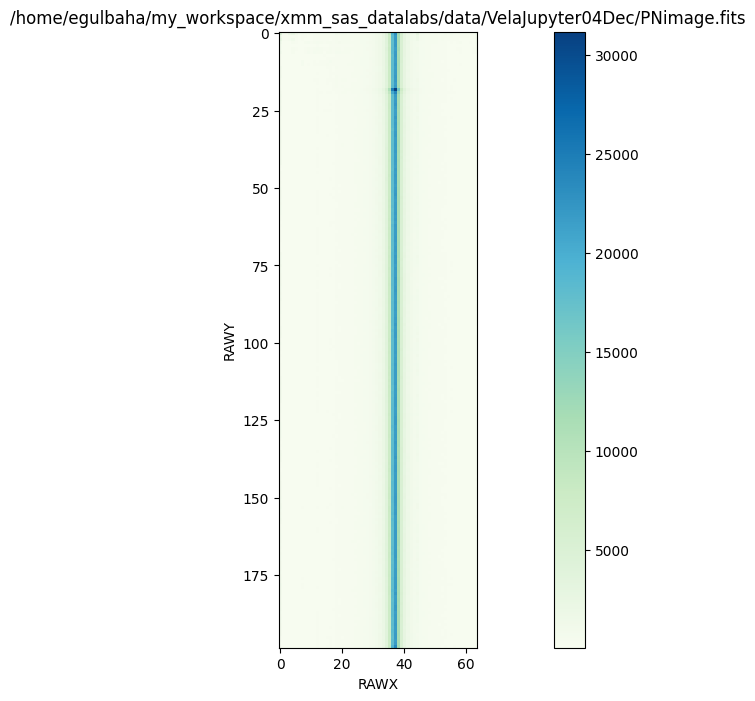

In [30]:
# Open the FITS file
with fits.open(out_IMFile) as hdul:
    # Assuming the image data is in the primary extension
    image_data = hdul[0].data

# Plotting the image
plt.figure(figsize=(20,8))
plt.imshow(image_data, cmap='GnBu')  
plt.colorbar()
plt.title(out_IMFile)
plt.xlabel('RAWX')
plt.ylabel('RAWY')
plt.show()

Below we load the image produced above in js9 so we can determine our RAWX1 and RAWX2 coordinates.

In [28]:
my_js9 = jpyjs9.JS9(width=600, height=700)

HTML(value="<iframe src='/datalabs/393fcf13918f01c7/js9/JS9-085e' width=600 height=700></iframe>")

In [29]:
visualise(my_js9, out_IMFile)

The values chosen in this case are taken from the paper of [Diez et al. (2023)](https://arxiv.org/pdf/2303.09631.pdf), where they study the same observation. However, the user can feel free to play around and experiment with their own values.

In [31]:
rawX1src = 32 #RAWX1 of the source rectangle region (in pixels)
rawX2src = 44 #RAWX2 of the source rectangle region (in pixels)

In [174]:
# Extract the source region lightcurve

# Define some parameters for filtering the event file and define the lightcurve binning

q_flag       = "#XMMEA_EP" # Quality flag for EPIC pn
n_pattern    = 4           # Pattern selection
pn_pi_min    = 500.        # Low energy range eV
pn_pi_max    = 10000.      # High energy range eV
lc_bin       = 283         # Lightcurve bin in secs

# Define the output ligthcurve file name

in_LCSRCFile = wdir+'/PN_source_lightcurve_raw_bin283sec.lc'   # Name of the output source lightcurve

In [175]:
# SAS Command
cmd        = "evselect" # SAS task to be executed                  

# Arguments of SAS Command
expression = f'{q_flag}&&(PATTERN<={n_pattern})&&(RAWX in [{rawX1src}:{rawX2src}])&&(PI in [{pn_pi_min}:{pn_pi_max}])'  # event filter expression
inargs     = [f'table={table}','energycolumn=PI','withrateset=yes',f'rateset={in_LCSRCFile}',
              f'timebinsize={lc_bin}','maketimecolumn=yes','makeratecolumn=yes',f'expression={expression}']

print("   Filter expression to use: "+expression+" \n")
print("   SAS command to be executed: "+cmd+", with arguments; \n")
inargs

   Filter expression to use: #XMMEA_EP&&(PATTERN<=4)&&(RAWX in [32:44])&&(PI in [500.0:10000.0]) 

   SAS command to be executed: evselect, with arguments; 



['table=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_clean_evt.fits',
 'energycolumn=PI',
 'withrateset=yes',
 'rateset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_source_lightcurve_raw_bin283sec.lc',
 'timebinsize=283',
 'maketimecolumn=yes',
 'makeratecolumn=yes',
 'expression=#XMMEA_EP&&(PATTERN<=4)&&(RAWX in [32:44])&&(PI in [500.0:10000.0])']

In [176]:
%%capture
w(cmd, inargs).run()

After extration we can plot the lightcurve of the selected source region:

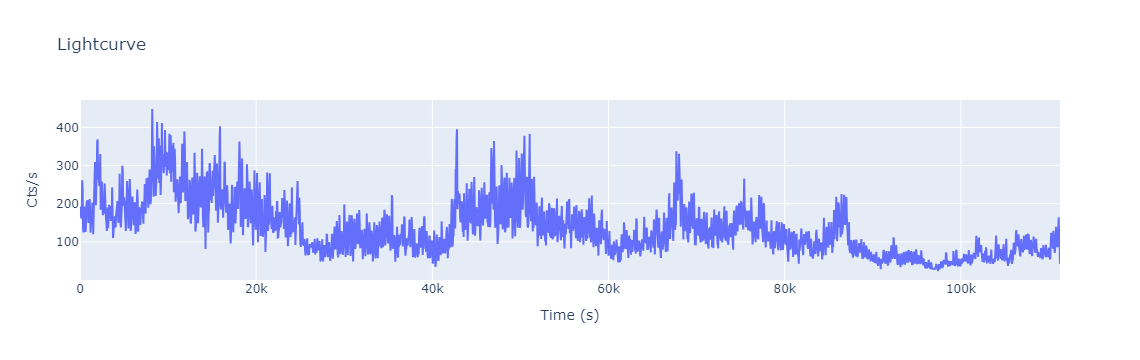

In [132]:
# Inspect light curve
name= ["XMM EPIC-pn (0.5-10 keV)"]
file_paths = [wdir+'/PN_source_lightcurve_raw_bin50sec.lc']

# Call the function to plot light curves
plotLC(file_paths, name, threshold= None, bin_size=None)

In [177]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

def plotLCmatplotlib2(fileNames, names, T0, P_orb, threshold=None, mjd_ref=58607):
    seconds_in_day = 86400  # Number of seconds in a day

      # Create the main plot and axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    for fileName, name in zip(fileNames, names):
        if fileName != "NOT FOUND":
            fitsFile = fits.open(fileName)
            prihdu = fitsFile[1].header

            # Extract threshold value from header if available
            if 'CUTVAL' in prihdu:
                threshold = prihdu['CUTVAL']

            cols = fitsFile[1].columns
            colName = None

            # Determine the correct column name for RATE or COUNTS
            for i, x in enumerate(cols.names):
                if "RATE" in x:
                    colName = cols.names[i]
                if "COUNTS" in x:
                    colName = cols.names[i]

            data = fitsFile[1].data
            xdata = data.field('TIME')  # Extract the time column
            ydata = data.field(colName)

            # Convert time from seconds to days since MJD reference
            xdata_days = (xdata / seconds_in_day) + mjd_ref

            # Calculate orbital phase
            orbital_phase = ((xdata - T0) / P_orb) % 1

            xmax = np.amax(xdata_days)
            xmin = np.amin(xdata_days)

            # Check if bin_size is provided
            
                # Plot the regular light curve
            ax1.plot(xdata_days, ydata, label=name, linestyle="", marker=".")

            # Set plot labels and titles
            if colName == 'RATE':
                ax1.set_title("XMM EPIC-pn (0.5-10 keV)")
                ax1.set_xlabel(f"Time (days since MJD {mjd_ref})")
                ax1.set_ylabel("Cts/s")
            else:
                ax1.set_title("XMM EPIC-pn (0.5-10 keV)")
                ax1.set_xlabel(f"Time (days since MJD {mjd_ref})")
                ax1.set_ylabel("Counts")

            # Add a threshold line if specified
            if threshold is not None and threshold != 'None':
                if colName == 'COUNTS':
                    threshold = float(threshold) * 100.

                y2data = [threshold] * len(xdata_days)
                ax1.plot(xdata_days, y2data, linestyle='--', color='red')
                ax1.text(xmin + 0.1 * (xmax - xmin), threshold + 0.01 * threshold,
                         str(threshold) + " cts/sec", ha='center', color='red')

            fitsFile.close()
        else:
            print("File not found " + fileName + "\n")

    # Add a secondary x-axis for orbital phase
    def phase_converter(days):
        seconds = (days - mjd_ref) * seconds_in_day
        return ((seconds - T0) / P_orb) % 1

    ax2 = ax1.secondary_xaxis('top', functions=(phase_converter, lambda phase: phase * P_orb / seconds_in_day + mjd_ref))
    ax2.set_xlabel("Orbital Phase")

    plt.legend()
    plt.show()



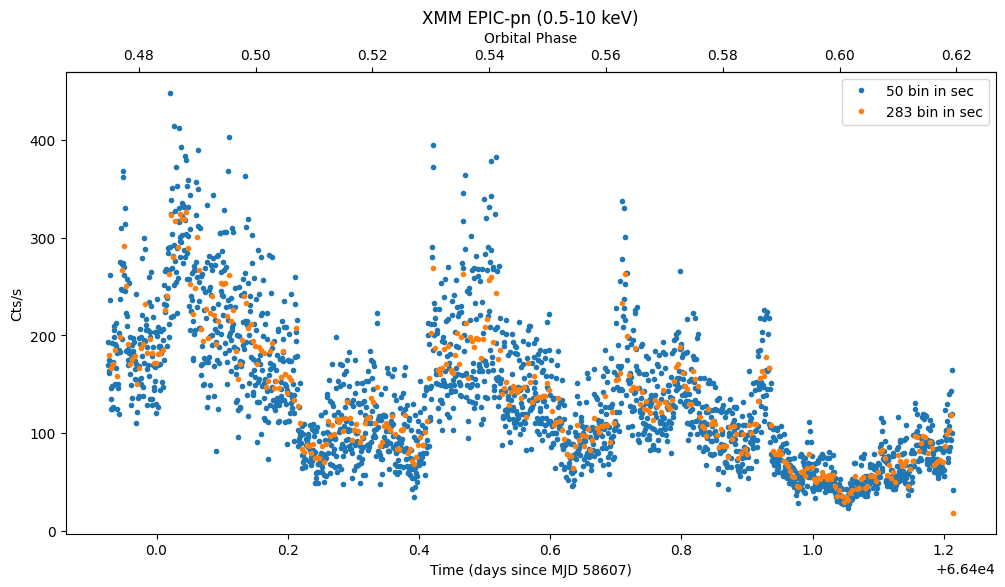

In [183]:
T0 = 52974.001 * 86400  # Reference time in seconds (convert from MJD)
P_orb = 8.9 * 86400  # Orbital period in seconds (e.g., 1 days)
name= ["50 bin in sec", "283 bin in sec"]
file_paths = [wdir+'/PN_source_lightcurve_raw_bin50sec.lc', wdir+'/PN_source_lightcurve_raw_bin283sec.lc']
plotLCmatplotlib2(file_paths, name, T0, P_orb, threshold=None, mjd_ref=58607)



Next moving onto extracting the lightcurve of the background region, where again pixel coordinate values have been taken from [Diez et al. (2023)](https://arxiv.org/pdf/2303.09631.pdf):

In [144]:
rawX1bkg = 3 #RAWX1 of the bkg rectangle region (in pixels)
rawX2bkg = 5 #RAWX2 of the bkg rectangle region (in pixels)

In [162]:
# Extract the background region lightcurve

# Define some parameters for filtering the event file and define the lightcurve binning

q_flag       = "#XMMEA_EP" # Quality flag for EPIC pn
n_pattern    = 4           # Pattern selection
pn_pi_min    = 500.        # Low energy range eV
pn_pi_max    = 10000.      # High energy range eV
lc_bin       = 1         # Lightcurve bin in secs

# Define the output ligthcurve file name

in_LCBKGFile = wdir+'/PN_lightcurve_background_raw_bin1sec.lc'   # Name of the output source lightcurve

In [163]:
# SAS Command
cmd        = "evselect" # SAS task to be executed                  

# Arguments of SAS Command
expression = f'{q_flag}&&(PATTERN<={n_pattern})&&(RAWX in [{rawX1bkg}:{rawX2bkg}])&&(PI in [{pn_pi_min}:{pn_pi_max}])'  # event filter expression
inargs     = [f'table={table}','energycolumn=PI','withrateset=yes',f'rateset={in_LCBKGFile}',
              f'timebinsize={lc_bin}','maketimecolumn=yes','makeratecolumn=yes',f'expression={expression}']

print("   Filter expression to use: "+expression+" \n")
print("   SAS command to be executed: "+cmd+", with arguments; \n")
inargs

   Filter expression to use: #XMMEA_EP&&(PATTERN<=4)&&(RAWX in [3:5])&&(PI in [500.0:10000.0]) 

   SAS command to be executed: evselect, with arguments; 



['table=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_clean_evt.fits',
 'energycolumn=PI',
 'withrateset=yes',
 'rateset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_lightcurve_background_raw_bin1sec.lc',
 'timebinsize=1',
 'maketimecolumn=yes',
 'makeratecolumn=yes',
 'expression=#XMMEA_EP&&(PATTERN<=4)&&(RAWX in [3:5])&&(PI in [500.0:10000.0])']

In [164]:
%%capture
w(cmd, inargs).run()

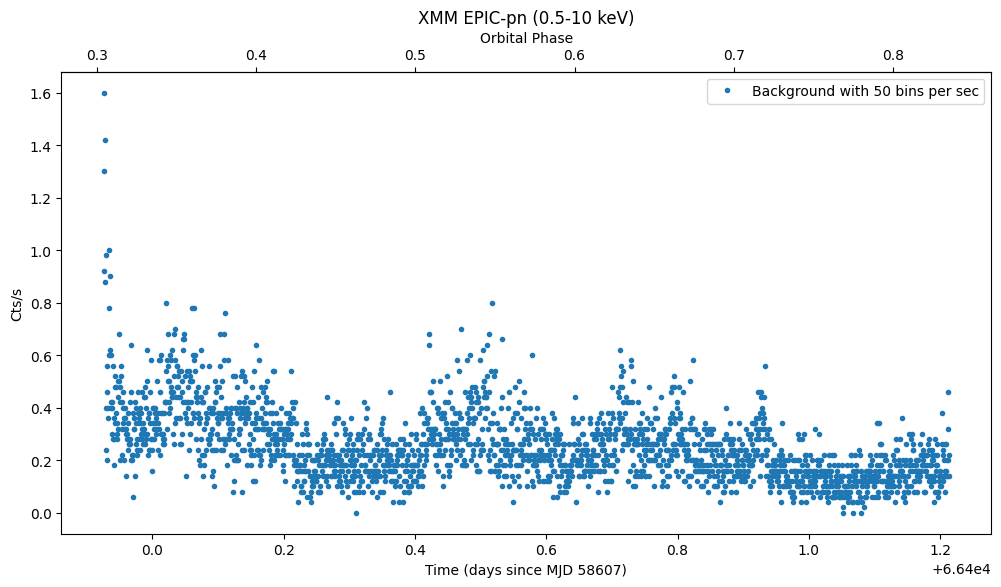

In [154]:
T0 = 58607 * 86400  # Reference time in seconds (convert from MJD)
P_orb = 1 * 86400  # Orbital period in seconds (e.g., 2 days)
name= ["Background with 50 bins per sec"]
file_paths = [in_LCBKGFile]
plotLCmatplotlib2(file_paths, name, T0, P_orb, threshold=None, mjd_ref=58607)



For background extraction we can run the command `epiclccorr` to perform correction of the lightcurve. Hence the command requires as input both light curves (which are used to establish the binning of the final corrected background subtracted light curve) and the event file.

In [155]:
# Define the output corrected ligthcurve file name

in_LCFile = wdir+'/PN_lccorr_bin1sec.lc'   # Name of the output corrected lightcurve

In [169]:
# Correct the light curve with the SAS task epiclccorr

# SAS Command
cmd        = "epiclccorr" # SAS task to be executed                  

# Arguments of SAS Command
inargs     = [f'eventlist={table}',f'srctslist={in_LCSRCFile}',f'outset={in_LCFile}',
              f'bkgtslist={in_LCBKGFile}','withbkgset=yes','applyabsolutecorrections=yes']

print("   SAS command to be executed: "+cmd+", with arguments; \n")
inargs

   SAS command to be executed: epiclccorr, with arguments; 



['eventlist=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_clean_evt.fits',
 'srctslist=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_source_lightcurve_raw_bin1sec.lc',
 'outset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_lccorr_bin1sec.lc',
 'bkgtslist=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_lightcurve_background_raw_bin1sec.lc',
 'withbkgset=yes',
 'applyabsolutecorrections=yes']

In [170]:

w(cmd, inargs).run()

Executing: 
epiclccorr srctslist='/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_source_lightcurve_raw_bin1sec.lc' eventlist='/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_clean_evt.fits' outset='/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_lccorr_bin1sec.lc' withbkgset='yes' bkgtslist='/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_lightcurve_background_raw_bin1sec.lc' applyabsolutecorrections='yes' withdetbins='no' detxbins='5' detybins='5' withsourcepos='no' sourcecoords='eqpos' sourcex='0' sourcey='0' allcamera='no' 
epiclccorr:- Executing (routine): epiclccorr srctslist=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_source_lightcurve_raw_bin1sec.lc eventlist=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_clean_evt.fits outset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_lccorr_bin1sec.lc bkgtslist=/home/egulbaha/my_wo

CalledProcessError: Command 'epiclccorr srctslist='/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_source_lightcurve_raw_bin1sec.lc' eventlist='/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_clean_evt.fits' outset='/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_lccorr_bin1sec.lc' withbkgset='yes' bkgtslist='/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_lightcurve_background_raw_bin1sec.lc' applyabsolutecorrections='yes' withdetbins='no' detxbins='5' detybins='5' withsourcepos='no' sourcecoords='eqpos' sourcex='0' sourcey='0' allcamera='no' ' returned non-zero exit status 1.

Let us visualize all the lightcurves produced using matplotlib lightcurve plotting function define by us through the plotLC python file, where we can bin some of the data for a cleaner look:

In [167]:
# Inspect the light curves

pn_threshold = 100          # cts/sec (only used here for display purposes. Draws a horizontal line at this value)
plt.figure(figsize=(20,8))  # Size of figure
binsize= 50
fileNames = [in_LCFile, in_LCSRCFile, in_LCBKGFile]
names = ['corrected', 'source', 'background']

plotLCmatplotlib(fileNames, names, threshold = pn_threshold, bin_size = binsize)      


FileNotFoundError: [Errno 2] No such file or directory: '/home/egulbaha/my_workspace/xmm_sas_datalabs/data/VelaJupyter04Dec/PN_lccorr_bin1sec.lc'

<Figure size 2000x800 with 0 Axes>

* ### Checking for Pile-Up

"Pile-up" happens when the detector registers multiple X-ray photons within a single readout frame as a single event. This occurs when the X-ray flux is so high that the detector cannot distinguish individual photons, and their signals overlap or pile up.

In XMM-Newton, each incoming X-ray photon is converted into an electronic signal. However, if multiple photons arrive at the detector in rapid succession, their signals may overlap, leading to an inaccurate representation of the detected X-ray events. This phenomenon can distort the measured X-ray spectra and impact the accuracy of scientific observations.

This step is usually advised to be applied before extracting the light curves as done on the previous step, however as the source we look at is immensely bright, the pile-up effect will not have an significant impact on the output light curve. However, we apply it here as before the extraction of the spectrum it is important, otherwise it could lead to false output with the spectrum having higher flux at high energies.

In [20]:
# Define some parameters for filtering the event file
rawX1src = 32
rawX2src = 44
pn_pi_min    = 550.        # Low energy range eV
pn_pi_max    = 10000.      # High energy range eV

# Define the output file name

filtered_output = wdir+'/PN_filtered_'+str(rawX1src)+'-'+str(rawX2src)+'.evt' 

In [21]:
# SAS Command
cmd        = "evselect" # SAS task to be executed                  

# Arguments of SAS Command
expression = f'(RAWX in [{rawX1src}:{rawX2src}])&&(PI in [{pn_pi_min}:{pn_pi_max}])'  # event filter expression
inargs     = [f'table={table}','withfilteredset=yes',f'filteredset={filtered_output}',
              'keepfilteroutput=yes',f'expression={expression}']

print("   Filter expression to use: "+expression+" \n")
print("   SAS command to be executed: "+cmd+", with arguments; \n")
inargs

   Filter expression to use: (RAWX in [32:44])&&(PI in [550.0:10000.0]) 

   SAS command to be executed: evselect, with arguments; 



['table=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_clean_evt.fits',
 'withfilteredset=yes',
 'filteredset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_filtered_32-44.evt',
 'keepfilteroutput=yes',
 'expression=(RAWX in [32:44])&&(PI in [550.0:10000.0])']

In [22]:
%%capture
w(cmd, inargs).run()

We can use the SAS command `epatplot` to plot EPIC pn and MOS event pattern statistics, which should help us see if pile-up has occured. For further in depth information the user is advised to look at the thread *How to Evaluate and test Pile-Up in an EPIC Source*.

In [23]:
%%capture
w('epatplot',[f'set={filtered_output}', 'device= /PNG']).run()

We can display the image produced:

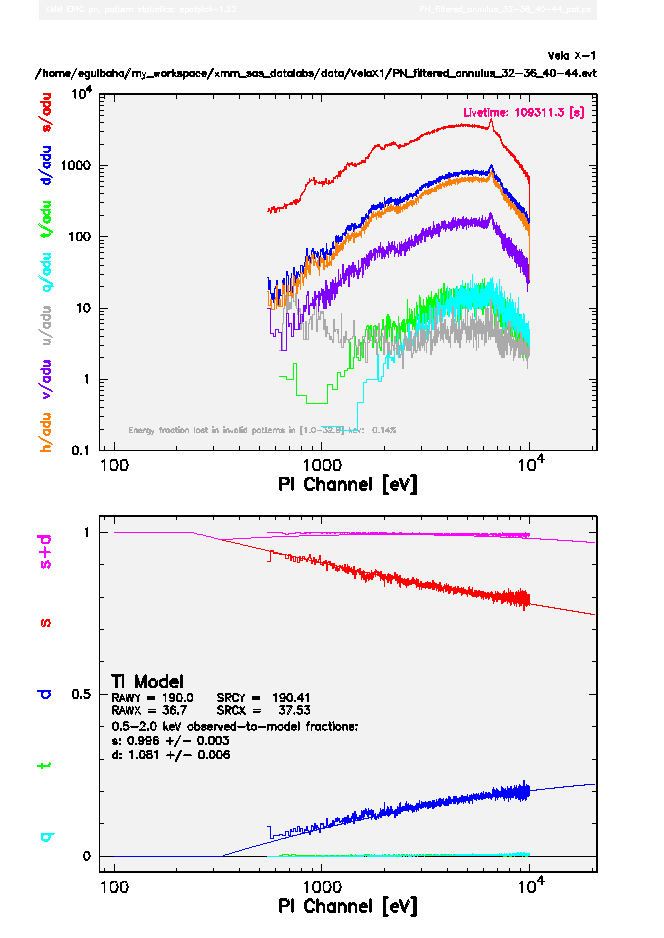

In [24]:
png_path = f'{home}/my_workspace/xmm_sas_datalabs/data/VelaX1/pgplot.png'
display(Image(filename=png_path))


As we can see the double events are higher than theory line and single ones are lower for our observation, thereby indicating the need for applying a pile-up correction, which we apply below:

In [25]:
# Define some parameters for filtering the event file 
rawX3src = 36
rawX4src = 40
pn_pi_min    = 550.        # Low energy range eV
pn_pi_max    = 10000.      # High energy range eV

# Define the output file name

filtered_output = wdir+'/PN_filtered_annulus_'+str(rawX1src)+'-'+str(rawX3src)+'_'+str(rawX4src)+'-'+str(rawX2src)+'.evt'   # Name of the output 

In [26]:
# SAS Command
cmd        = "evselect" # SAS task to be executed                  

# Arguments of SAS Command
expression = f'(RAWX in [{rawX1src}:{rawX3src}] || RAWX in [{rawX4src}:{rawX2src}])&&(PI in [{pn_pi_min}:{pn_pi_max}])'  # event filter expression
inargs     = [f'table={table}','withfilteredset=yes',f'filteredset={filtered_output}',
              'keepfilteroutput=yes',f'expression={expression}']

print("   Filter expression to use: "+expression+" \n")
print("   SAS command to be executed: "+cmd+", with arguments; \n")
inargs

   Filter expression to use: (RAWX in [32:36] || RAWX in [40:44])&&(PI in [550.0:10000.0]) 

   SAS command to be executed: evselect, with arguments; 



['table=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_clean_evt.fits',
 'withfilteredset=yes',
 'filteredset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_filtered_annulus_32-36_40-44.evt',
 'keepfilteroutput=yes',
 'expression=(RAWX in [32:36] || RAWX in [40:44])&&(PI in [550.0:10000.0])']

In [35]:
%%capture
w(cmd, inargs).run()

In [36]:
%%capture
w('epatplot',[f'set={filtered_output}', 'device= /PNG']).run()

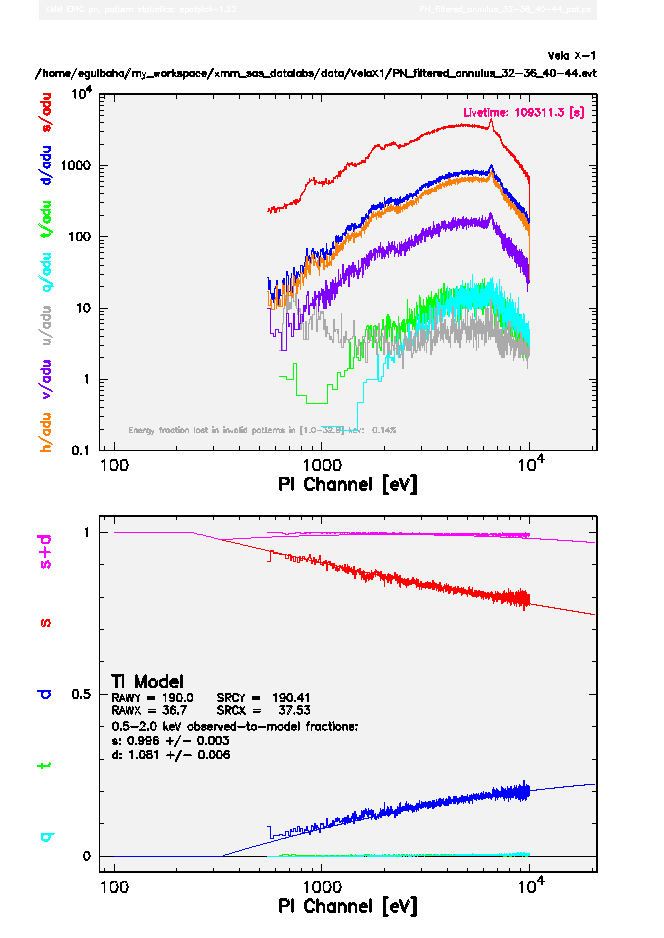

In [37]:
png_path = f'{home}/my_workspace/xmm_sas_datalabs/data/VelaX1/pgplot.png'
display(Image(filename=png_path))

Now we can see that after the correction the theory and observation match and we have accounted for pile-up, therefore we can move onto extracting the spectrum of the source safely.

* ### Spectrum Extraction

No we can produce a spectrum for the source region, by avoiding pile-up regions:

In [27]:
rawX1src= 32
rawX2src = 44

In [28]:
#core of the psf coordinates:
rawX3src = 36
rawX4src = 40
spectrumset= wdir+ '/PN_source_spectrum_raw_'+str(rawX1src)+'-'+str(rawX3src)+'_'+str(rawX4src)+'-'+str(rawX2src)+'.fits'

In [29]:
# SAS Command
cmd        = "evselect" # SAS task to be executed                  

# Arguments of SAS Command
expression = f'(FLAG==0) && (PATTERN<=4) && (RAWX in [{rawX1src}:{rawX3src}] || RAWX in [{rawX4src}:{rawX2src}])'  # event filter expression
inargs     = [f'table={table}','withspectrumset=yes',f'spectrumset={spectrumset}',
              'energycolumn=PI', 'spectralbinsize=5', 'withspecranges=yes', 'specchannelmin=0', 'specchannelmax=20479',f'expression={expression}']

print("   Filter expression to use: "+expression+" \n")
print("   SAS command to be executed: "+cmd+", with arguments; \n")
inargs

   Filter expression to use: (FLAG==0) && (PATTERN<=4) && (RAWX in [32:36] || RAWX in [40:44]) 

   SAS command to be executed: evselect, with arguments; 



['table=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_clean_evt.fits',
 'withspectrumset=yes',
 'spectrumset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_source_spectrum_raw_32-36_40-44.fits',
 'energycolumn=PI',
 'spectralbinsize=5',
 'withspecranges=yes',
 'specchannelmin=0',
 'specchannelmax=20479',
 'expression=(FLAG==0) && (PATTERN<=4) && (RAWX in [32:36] || RAWX in [40:44])']

In [30]:
%%capture
w(cmd, inargs).run()

In [31]:
# SAS Command
cmd        = "backscale" # SAS task to be executed                  

# Arguments of SAS Command
inargs     = [f'spectrumset={spectrumset}',f'badpixlocation={table}']

print("   SAS command to be executed: "+cmd+", with arguments; \n")
inargs

   SAS command to be executed: backscale, with arguments; 



['spectrumset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_source_spectrum_raw_32-36_40-44.fits',
 'badpixlocation=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_clean_evt.fits']

In [32]:
%%capture
w(cmd, inargs).run()

In [33]:
# Define some parameters for rmfgen

# Define the output redistribution matrix file name

in_RESPFile = wdir+'/PN_'+str(rawX1src)+'-'+str(rawX3src)+'_'+str(rawX4src)+'-'+str(rawX2src)+'.rmf'   # Name of the output redistribution

In [34]:
# SAS Command
cmd        = "rmfgen" # SAS task to be executed                  

# Arguments of SAS Command
inargs     = [f'spectrumset={spectrumset}',f'rmfset={in_RESPFile}']

print("   SAS command to be executed: "+cmd+", with arguments; \n")
inargs

   SAS command to be executed: rmfgen, with arguments; 



['spectrumset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_source_spectrum_raw_32-36_40-44.fits',
 'rmfset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_32-36_40-44.rmf']

In [35]:
%%capture
w(cmd, inargs).run()

In [36]:
# Define some parameters for arfgen

# Define the output ancillary file name

in_ARFFile = wdir+'/PN_'+str(rawX1src)+'-'+str(rawX3src)+'_'+str(rawX4src)+'-'+str(rawX2src)+'.arf'   # Name of the output ancillary

In [37]:
# SAS Command
cmd        = "arfgen" # SAS task to be executed                  

print("   Checking for Response File ..... \n")
# Check if RESP file is available.
if os.path.isfile(in_RESPFile):
    print ("File "+in_RESPFile+" exists. \n")
else:
    print ("File "+in_RESPFile+" does not exist, please check. \n")

# Arguments of SAS Command
inargs     = [f'spectrumset={spectrumset}',f'arfset={in_ARFFile}',
              'withrmfset=yes',f'rmfset={in_RESPFile}',f'badpixlocation={table}','detmaptype=psf', 'applyabsfluxcorr=yes']

print("   SAS command to be executed: "+cmd+", with arguments; \n")
inargs

   Checking for Response File ..... 

File /home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_32-36_40-44.rmf exists. 

   SAS command to be executed: arfgen, with arguments; 



['spectrumset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_source_spectrum_raw_32-36_40-44.fits',
 'arfset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_32-36_40-44.arf',
 'withrmfset=yes',
 'rmfset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_32-36_40-44.rmf',
 'badpixlocation=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_clean_evt.fits',
 'detmaptype=psf',
 'applyabsfluxcorr=yes']

In [38]:
%%capture
w(cmd, inargs).run()

In [39]:
# Define some parameters for specgruop

# Define the output ancillary file name
#spectrumset = '/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velax1ter/PN_source_spectrum_raw_32-36_40-44.fits'
#in_RESPFile = '/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velax1ter/PN_32-36_40-44.rmf'
#in_ARFFile = '/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velax1ter/PN_32-36_40-44.arf'
in_GRPFile = '/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_spectrum_grp_32-36_40-44.fits'   # Name of the output specgruop

In [40]:
# SAS Command
cmd        = "specgroup" # SAS task to be executed                  

# Arguments of SAS Command
inargs     = [f'spectrumset={spectrumset}','mincounts=25','oversample=3',
              f'rmfset={in_RESPFile}',f'arfset={in_ARFFile}',
              f'groupedset={in_GRPFile}']

print("   SAS command to be executed: "+cmd+", with arguments; \n")
inargs

   SAS command to be executed: specgroup, with arguments; 



['spectrumset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_source_spectrum_raw_32-36_40-44.fits',
 'mincounts=25',
 'oversample=3',
 'rmfset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_32-36_40-44.rmf',
 'arfset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_32-36_40-44.arf',
 'groupedset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_spectrum_grp_32-36_40-44.fits']

In [41]:

w(cmd, inargs).run()

Executing: 
specgroup spectrumset='/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_source_spectrum_raw_32-36_40-44.fits' overwrite='no' groupedset='/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_spectrum_grp_32-36_40-44.fits' withbgdset='no' backgndset='' withCounts='yes' mincounts='25' withminSN='no' minSN='5' withratioabovebgnd='no' ratioabovebgnd='' withoversampling='yes' oversample='3' withtemplate='no' grouptemplate='grptemplate.ds' withranges='no' ranges='' withRegularBins='no' regbinstart='' regbinend='' regbinwid='' units='CHAN' withrmfset='yes' rmfset='/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_32-36_40-44.rmf' witharfset='yes' arfset='/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_32-36_40-44.arf' addfilenames='yes' hightolow='no' lastbin='addtogroup' setbad='CCF' 
specgroup:- Executing (routine): specgroup spectrumset=/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultc

Now that we have acquired the final spectrum, we can load the file using pyXspec:

In [42]:
# Before you start, clear all data and models

AllModels.clear()  # Clear all models
AllData.clear()    # Clear all data

In [43]:
# Load the group spectral file

# The group file already contains in the header the names of all the necessary files needed by xspec
# (source and background spectra, response and ancillery files)

data1 = Spectrum('/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_spectrum_grp_32-36_40-44.fits')  # load spectra groupped file
data2= Spectrum('/home/egulbaha/my_workspace/xmm_sas_datalabs/data/camillespectra/nondefault/PN_spectrum_grp_32-36_40-44.fits')
data3= Spectrum('/home/egulbaha/my_workspace/xmm_sas_datalabs/data/velax1ter/PN_spectrum_grp_32-36_40-44.fits')
AllData.show()                # inspect loaded data


1 spectrum  in use
 
Spectral Data File: /home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_spectrum_grp_32-36_40-44.fits  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.907e+01 +/- 2.119e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-238
  Telescope: XMM Instrument: EPN  Channel Type: PI
  Exposure Time: 1.093e+05 sec
 Using fit statistic: chi
 Using Response (RMF) File            /home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_32-36_40-44.rmf for Source 1
 Using Auxiliary Response (ARF) File  /home/egulbaha/my_workspace/xmm_sas_datalabs/data/velaX1defaultcal/PN_32-36_40-44.arf


2 spectra  in use
 
Spectral Data File: /home/egulbaha/my_workspace/xmm_sas_datalabs/data/camillespectra/nondefault/PN_spectrum_grp_32-36_40-44.fits  Spectrum 2
Net count rate (cts/s) for Spectrum:2  4.907e+01 +/- 2.119e-02
 Assigned to Data Group 1 and Plot Group 2
  Noticed Channels:  1-238
  Telescope: XMM Instrument: EPN  Channel Type: 

In [44]:
# Set the plot device to /null to suppress graphical output

Plot.device = "/null"

In [45]:
# First inspection of the spectrum

Plot.xAxis = "keV"        # set X axis to energy units
Plot.xLog  = True         # log scale
Plot.yLog  = True         # log scale
Plot("data")   # plot source and background spectra

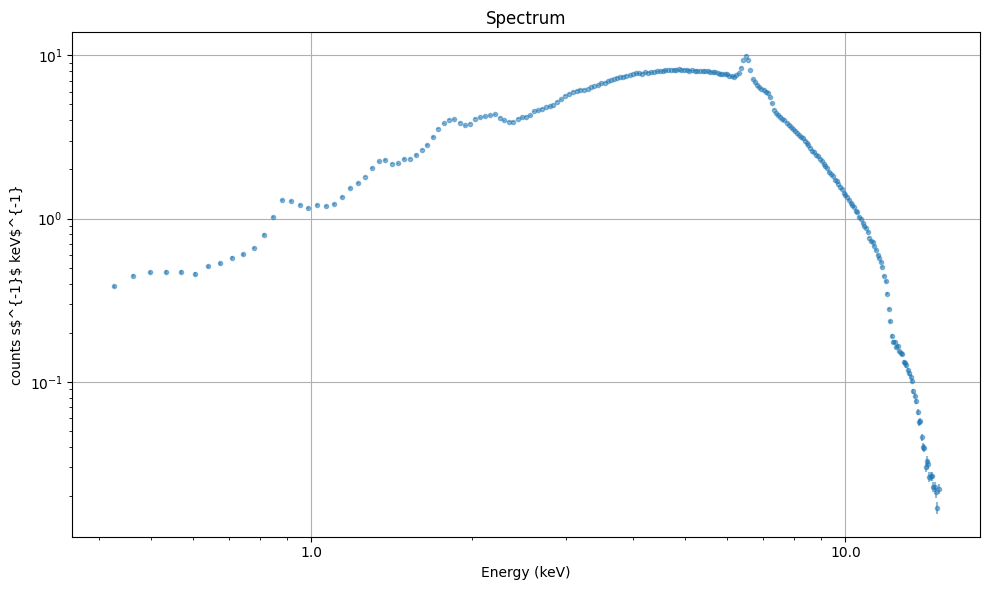

In [30]:
# Create a Matplotlib figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Extract data from the XSPEC plot
x = Plot.x(1)  # X-axis values
y = Plot.y(1)  # Y-axis values
yerr = Plot.yErr(1)  # Y-axis error values

# Plot your spectrum with error bars
ax.errorbar(x, y, yerr=yerr, marker='.', linestyle='none', label='Your Spectrum', alpha=0.5)

# Customize the plot appearance
ax.set_xscale('log')  # Set X-axis scale to logarithmic
ax.set_yscale('log')  # Set Y-axis scale to logarithmic
ax.set_xlabel('Energy (keV)')  # Set X-axis label
ax.set_ylabel(r'counts s$^{-1}$ keV$^{-1}')  # Set Y-axis label
ax.xaxis.set_major_formatter(ScalarFormatter())  # Format X-axis labels
ax.set_title('Spectrum')  # Set the plot title
ax.grid()  # Display grid lines
# Show the plot
plt.tight_layout()  # Ensure a tight layout
plt.show()  # Display the plot

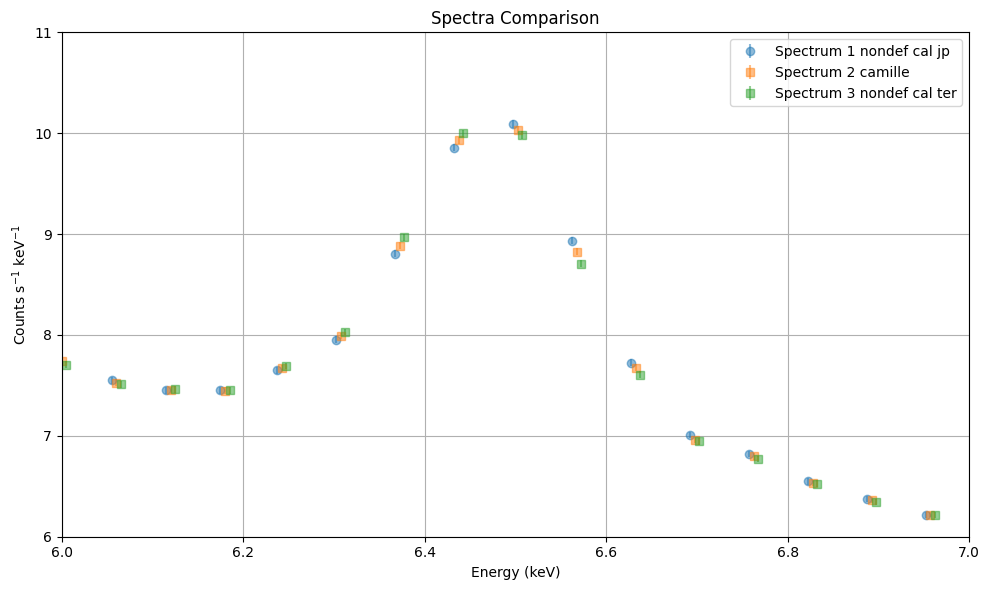

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))

# Extract data for the first spectrum
x1 = Plot.x(1)          # X-axis values for first spectrum
y1 = Plot.y(1)          # Y-axis values for first spectrum
yerr1 = Plot.yErr(1)    # Y-axis error values for first spectrum

# Extract data for the second spectrum
x2 = Plot.x(2)          # X-axis values for second spectrum
y2 = Plot.y(2)          # Y-axis values for second spectrum
yerr2 = Plot.yErr(2)    # Y-axis error values for second spectrum

x3 = Plot.x(3)          # X-axis values for first spectrum
y3 = Plot.y(3)          # Y-axis values for first spectrum
yerr3 = Plot.yErr(3)

# Plot both spectra with error bars
ax.errorbar(x1, y1, yerr=yerr1, marker='o', linestyle='none', label='Spectrum 1 nondef cal jp', alpha=0.5)
ax.errorbar(x2, y2, yerr=yerr2, marker='s', linestyle='none', label='Spectrum 2 camille', alpha=0.5)
ax.errorbar(x3, y3, yerr=yerr3, marker='s', linestyle='none', label='Spectrum 3 nondef cal ter', alpha=0.5)

ax.set_xlim(6, 7)
ax.set_ylim(6, 11)

# Customize the plot appearance
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('Counts s$^{-1}$ keV$^{-1}$')
ax.xaxis.set_major_formatter(ScalarFormatter())  # Format X-axis labels
ax.set_title("Spectra Comparison")
ax.legend()  # Add a legend to distinguish the spectra
ax.grid()    # Display grid lines

# Display the plot
plt.tight_layout()
plt.savefig("spectra_comparison_nondefaultcal3Fe.png", dpi=300)
plt.show()

Above we have visualised an average spectrum, and to fit model the user needs to look at time resolved spectroscopy. In this thread we will not go into the specifics of model fitting for the spectrum.
***
### Conclusions

Congrats!✨ 

By following this thread you have:

* processed ODF files for the X-ray binary Vela X-1.
* applied calibration in timing mode.
* produced lightcurves of the source and the background.
* checked and corrected for plie-up.
* produced a spectrum of the object and plotted it using pyXspec.

This shows how a further analysis can be done on an object observed by XMM-Newton in the XMM-Newton-SAS Datalab, where you can swiftly get your data and analyse it with all the major tools necessary available at your disposal. The further analysis and model fitting of the object can be advanced by the reader, by exploring the tools at disposal by pyXspec, for more information please refer to the [pyXspec information page](https://heasarc.gsfc.nasa.gov/xanadu/xspec/python/html/index.html).